In [ ]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import re
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
import nltk
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers.recurrent import LSTM
from keras.layers import Activation, Dense
from sklearn.metrics import accuracy_score
import sklearn.metrics as metrics
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/My Drive/Reviews.csv')

In [ ]:
df

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...
...,...,...,...,...,...,...,...,...,...,...
568449,568450,B001EO7N10,A28KG5XORO54AY,Lettie D. Carter,0,0,5,1299628800,Will not do without,Great for sesame chicken..this is a good if no...
568450,568451,B003S1WTCU,A3I8AFVPEE8KI5,R. Sawyer,0,0,2,1331251200,disappointed,I'm disappointed with the flavor. The chocolat...
568451,568452,B004I613EE,A121AA1GQV751Z,"pksd ""pk_007""",2,2,5,1329782400,Perfect for our maltipoo,"These stars are small, so you can give 10-15 o..."
568452,568453,B004I613EE,A3IBEVCTXKNOH,"Kathy A. Welch ""katwel""",1,1,5,1331596800,Favorite Training and reward treat,These are the BEST treats for training and rew...


In [ ]:
#Summary of the dataframe
df.info()  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568438 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [ ]:
#Sorting values
sorted_data=df.sort_values('ProductId', kind='quicksort', na_position='last')
sorted_data

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
150528,150529,0006641040,A25ACLV5KPB4W,"Matt Hetling ""Matt""",0,1,4,1108425600,"Nice cadence, catchy rhymes",In June<br />I saw a charming group<br />of ro...
150506,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,4,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...
150505,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,4,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc..."
150504,150505,0006641040,A2PTSM496CF40Z,"Jason A. Teeple ""Nobody made a greater mistak...",1,1,4,1210809600,A classic,Get the movie or sound track and sing along wi...
150503,150504,0006641040,AQEYF1AXARWJZ,"Les Sinclair ""book maven""",1,1,4,1212278400,Chicken Soup with Rice,A very entertaining rhyming story--cleaver and...
...,...,...,...,...,...,...,...,...,...,...
191720,191721,B009UOFTUI,AJVB004EB0MVK,D. Christofferson,0,0,1,1345852800,weak coffee not good for a premium product and...,"This coffee supposedly is premium, it tastes w..."
1477,1478,B009UOFU20,AJVB004EB0MVK,D. Christofferson,0,0,1,1345852800,weak coffee not good for a premium product and...,"This coffee supposedly is premium, it tastes w..."
328481,328482,B009UUS05I,ARL20DSHGVM1Y,Jamie,0,0,5,1331856000,Perfect,The basket was the perfect sympathy gift when ...
5702,5703,B009WSNWC4,AMP7K1O84DH1T,ESTY,0,0,5,1351209600,DELICIOUS,Purchased this product at a local store in NY ...


In [ ]:
# Removing the duplicates
df=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)

In [ ]:
# Shape of the dataframe after removing duplicates
df.shape

(393933, 10)

In [ ]:
# Removing instances of unhelpful reviews
df=df[df["HelpfulnessNumerator"]<=df["HelpfulnessDenominator"]]
df.shape

(393931, 10)

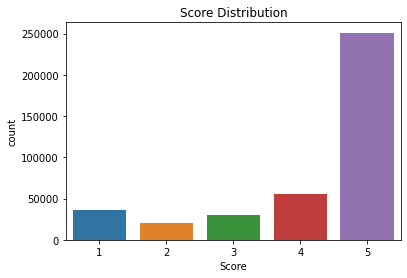

In [ ]:
ax = plt.axes()
sns.countplot(df.Score,ax=ax)
ax.set_title('Score Distribution')
plt.show()

In [ ]:
#Removing Urls
df['Text'] = df['Text'].replace({'Text':  r'^https:\/\/.*[\r\n]*'}, '',regex=True)
df['Text'] = df['Text'].apply(lambda x: re.split('https:\/\/.*', str(x))[0])
df[df['Text'].str.contains('https')==True]
df

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
150528,150529,0006641040,A25ACLV5KPB4W,"Matt Hetling ""Matt""",0,1,4,1108425600,"Nice cadence, catchy rhymes",In June<br />I saw a charming group<br />of ro...
150506,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,4,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...
150505,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,4,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc..."
150504,150505,0006641040,A2PTSM496CF40Z,"Jason A. Teeple ""Nobody made a greater mistak...",1,1,4,1210809600,A classic,Get the movie or sound track and sing along wi...
150503,150504,0006641040,AQEYF1AXARWJZ,"Les Sinclair ""book maven""",1,1,4,1212278400,Chicken Soup with Rice,A very entertaining rhyming story--cleaver and...
...,...,...,...,...,...,...,...,...,...,...
193171,193172,B009RSR8HO,A3JJTHP8T7A8LY,"Joanne Eklund ""Joanne""",0,0,5,1350432000,Zero,FTS Zero is the best sweetener I have ever tri...
188388,188389,B009SF0TN6,A1L0GWGRK4BYPT,Bety Robinson,0,0,5,1350518400,Amazing!! Great sauce for everything!,You have to try this sauce to believe it! It s...
221794,221795,B009SR4OQ2,A32A6X5KCP7ARG,sicamar,1,1,5,1350604800,Awesome Taste,I bought this Hazelnut Paste (Nocciola Spread)...
5702,5703,B009WSNWC4,AMP7K1O84DH1T,ESTY,0,0,5,1351209600,DELICIOUS,Purchased this product at a local store in NY ...


In [ ]:
# Searching rows with HTML tags
df[df['Text'].str.contains('<.*?>')==True]

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
150528,150529,0006641040,A25ACLV5KPB4W,"Matt Hetling ""Matt""",0,1,4,1108425600,"Nice cadence, catchy rhymes",In June<br />I saw a charming group<br />of ro...
150497,150498,0006641040,A3SJWISOCP31TR,R. J. Wells,2,2,5,1176336000,A Gem of a Book,This is a wonderful little book. I loved it 40...
150496,150497,0006641040,A1HKYQOFC8ZZCH,"Maria Apolloni ""lanarossa""",2,2,1,1334707200,"The story is great, the softcover book is disa...",I give five stars to the Maurice Sendak story....
150495,150496,0006641040,A3KKR87BJ0C595,"Gretchen Goodfellow ""Lover of children's lit""",3,3,5,1111363200,"You'll use it once, you'll use it twice",One of my earliest memories is of this book. ...
150492,150493,0006641040,AMX0PJKV4PPNJ,"E. R. Bird ""Ramseelbird""",71,72,4,1096416000,Read it once. Read it twice. Reading Chicken S...,"These days, when a person says, ""chicken soup""..."
...,...,...,...,...,...,...,...,...,...,...
193166,193167,B009RSR8HO,A5F9OUO3F2N7C,Jan,0,0,5,1350604800,The Best Ever,Zero sweetner is the BEST I have ever used.One...
193167,193168,B009RSR8HO,A1L130V9KINC45,mildred rosa,0,0,5,1350518400,love sweetener,Great product not too expensive easy to use. S...
193162,193163,B009RSR8HO,A1QX7TAALGCUKM,"H.B. ""H.B.""",2,2,5,1350432000,The Best Sweetener I've Ever Used!,I have been using this product a bit over six ...
188388,188389,B009SF0TN6,A1L0GWGRK4BYPT,Bety Robinson,0,0,5,1350518400,Amazing!! Great sauce for everything!,You have to try this sauce to believe it! It s...


In [ ]:
#Removing HTML tags
df['Text'] = [re.sub(r'<.*?>', ' ', e) for e in df['Text']]
df[df['Text'].str.contains('<.*?>')==True]
df

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
150528,150529,0006641040,A25ACLV5KPB4W,"Matt Hetling ""Matt""",0,1,4,1108425600,"Nice cadence, catchy rhymes",In June I saw a charming group of roses all be...
150506,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,4,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...
150505,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,4,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc..."
150504,150505,0006641040,A2PTSM496CF40Z,"Jason A. Teeple ""Nobody made a greater mistak...",1,1,4,1210809600,A classic,Get the movie or sound track and sing along wi...
150503,150504,0006641040,AQEYF1AXARWJZ,"Les Sinclair ""book maven""",1,1,4,1212278400,Chicken Soup with Rice,A very entertaining rhyming story--cleaver and...
...,...,...,...,...,...,...,...,...,...,...
193171,193172,B009RSR8HO,A3JJTHP8T7A8LY,"Joanne Eklund ""Joanne""",0,0,5,1350432000,Zero,FTS Zero is the best sweetener I have ever tri...
188388,188389,B009SF0TN6,A1L0GWGRK4BYPT,Bety Robinson,0,0,5,1350518400,Amazing!! Great sauce for everything!,You have to try this sauce to believe it! It s...
221794,221795,B009SR4OQ2,A32A6X5KCP7ARG,sicamar,1,1,5,1350604800,Awesome Taste,I bought this Hazelnut Paste (Nocciola Spread)...
5702,5703,B009WSNWC4,AMP7K1O84DH1T,ESTY,0,0,5,1351209600,DELICIOUS,Purchased this product at a local store in NY ...


In [ ]:
# Checking the rows with digits
df[df['Text'].str.contains('\d')==True]


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
150502,150503,0006641040,A3R5XMPFU8YZ4D,"Her Royal Motherliness ""Nana""",1,1,5,1233964800,so fun to read,This is my grand daughter's and my favorite bo...
150500,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,5,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...
150497,150498,0006641040,A3SJWISOCP31TR,R. J. Wells,2,2,5,1176336000,A Gem of a Book,This is a wonderful little book. I loved it 40...
150494,150495,0006641040,A2QXYSXGQ2PKAU,Support for Providers,3,3,3,1129507200,Disappointed,When I ordered a large amount of these books t...
150492,150493,0006641040,AMX0PJKV4PPNJ,"E. R. Bird ""Ramseelbird""",71,72,4,1096416000,Read it once. Read it twice. Reading Chicken S...,"These days, when a person says, ""chicken soup""..."
...,...,...,...,...,...,...,...,...,...,...
193173,193174,B009RSR8HO,A4P6AN2L435PV,romarc,0,0,5,1350432000,LOVE!! LOVE!!,"LOVE, LOVE this sweetener!! I use it in all m..."
193175,193176,B009RSR8HO,A76WHW051R3KV,"Shawn ""Shawn""",0,0,5,1350432000,My #1 Sweetener of choice,What a wonderful product! It's perfect to use ...
193168,193169,B009RSR8HO,A3M3S2NCVZ8UXF,Stephanie,0,0,5,1350518400,Fat to Skinny zero,I have been using this product for 4 months no...
188388,188389,B009SF0TN6,A1L0GWGRK4BYPT,Bety Robinson,0,0,5,1350518400,Amazing!! Great sauce for everything!,You have to try this sauce to believe it! It s...


In [ ]:
# Removing digits
df['Text'] = [re.sub("\S*\d\S*", "", e).strip() for e in df['Text']]
df[df['Text'].str.contains('\d')==True]

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text


In [ ]:
#Decontracting
df['Text'] = [re.sub(r"won\'t", "will not", e) for e in df['Text']]
df['Text'] = [re.sub(r"can\'t", "can not", e) for e in df['Text']]
df['Text'] = [re.sub(r"n\'t", " not", e) for e in df['Text']]
df['Text'] = [re.sub(r"\'re", " are", e) for e in df['Text']]
df['Text'] = [re.sub(r"\'s", " is", e) for e in df['Text']]
df['Text'] = [re.sub(r"\'d", " would", e) for e in df['Text']]
df['Text'] = [re.sub(r"\'ll", " will", e) for e in df['Text']]
df['Text'] = [re.sub(r"\'t", " not", e) for e in df['Text']]
df['Text'] = [re.sub(r"\'ve", " have", e) for e in df['Text']]
df['Text'] = [re.sub(r"\'m", " am", e) for e in df['Text']]
df['Text'] = [re.sub(r"\'isn\'t", " is not", e) for e in df['Text']]

In [ ]:
#removing non-word characters
df['Text'] = [re.sub('[^A-Za-z]+', ' ', e) for e in df['Text']]

In [ ]:
# Converting the reviews to lowercase
df['Text'] = df['Text'].str.lower()

In [ ]:
df

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
150528,150529,0006641040,A25ACLV5KPB4W,"Matt Hetling ""Matt""",0,1,4,1108425600,"Nice cadence, catchy rhymes",in june i saw a charming group of roses all be...
150506,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,4,1191456000,chicken soup with rice months,this is a fun way for children to learn their ...
150505,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,4,1194739200,"Love the book, miss the hard cover version",i grew up reading these sendak books and watch...
150504,150505,0006641040,A2PTSM496CF40Z,"Jason A. Teeple ""Nobody made a greater mistak...",1,1,4,1210809600,A classic,get the movie or sound track and sing along wi...
150503,150504,0006641040,AQEYF1AXARWJZ,"Les Sinclair ""book maven""",1,1,4,1212278400,Chicken Soup with Rice,a very entertaining rhyming story cleaver and ...
...,...,...,...,...,...,...,...,...,...,...
193171,193172,B009RSR8HO,A3JJTHP8T7A8LY,"Joanne Eklund ""Joanne""",0,0,5,1350432000,Zero,fts zero is the best sweetener i have ever tri...
188388,188389,B009SF0TN6,A1L0GWGRK4BYPT,Bety Robinson,0,0,5,1350518400,Amazing!! Great sauce for everything!,you have to try this sauce to believe it it st...
221794,221795,B009SR4OQ2,A32A6X5KCP7ARG,sicamar,1,1,5,1350604800,Awesome Taste,i bought this hazelnut paste nocciola spread a...
5702,5703,B009WSNWC4,AMP7K1O84DH1T,ESTY,0,0,5,1351209600,DELICIOUS,purchased this product at a local store in ny ...


In [ ]:
nltk.download('stopwords')
stop = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
stop

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [ ]:
df['Text'] = df['Text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [ ]:
df['Text']

150528    june saw charming group roses begin droop pepp...
150506    fun way children learn months year learn poems...
150505    grew reading sendak books watching really rosi...
150504    get movie sound track sing along carol king gr...
150503    entertaining rhyming story cleaver catchy illu...
                                ...                        
193171    fts zero best sweetener ever tried aftertaste ...
188388    try sauce believe starts little sweet honey ta...
221794    bought hazelnut paste nocciola spread local sh...
5702      purchased product local store ny kids love qui...
327600    purchased send son away college delivered righ...
Name: Text, Length: 393931, dtype: object

In [ ]:
#Finding the median
median_score = df.Score.median()
median_score

5.0

In [ ]:
#Creating new column Sentiment and assigning value based on the score
df.loc[df['Score'] < median_score, 'Sentiment'] = 0
df.loc[df['Score'] >= median_score, 'Sentiment'] = 1 
df.astype({'Sentiment': 'int32'}).dtypes

Id                         int64
ProductId                 object
UserId                    object
ProfileName               object
HelpfulnessNumerator       int64
HelpfulnessDenominator     int64
Score                      int64
Time                       int64
Summary                   object
Text                      object
Sentiment                  int32
dtype: object

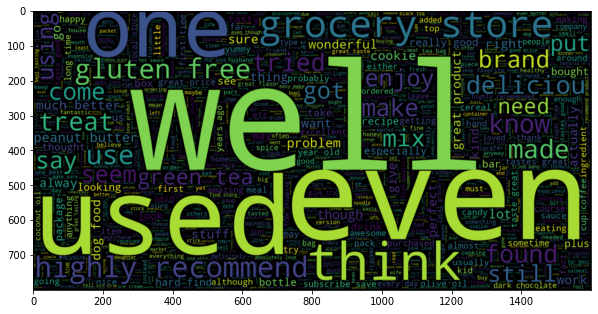

In [ ]:
#wordcloud for positive reviews
from wordcloud import WordCloud
import matplotlib.pyplot as plt
plt.figure(figsize = (10,10)) # Text with bad/average reviews
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.Sentiment == 1].Text))
plt.imshow(wc , interpolation = 'bilinear')

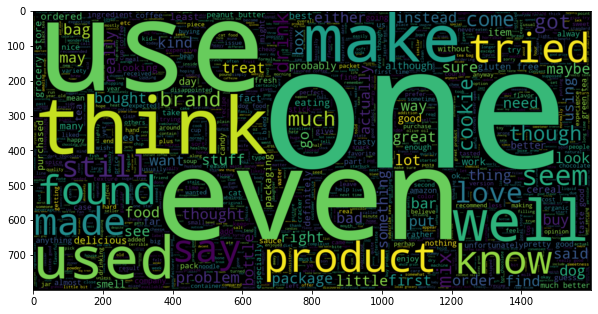

In [ ]:
#wordcloud for negative reviews
from wordcloud import WordCloud
import matplotlib.pyplot as plt
plt.figure(figsize = (10,10)) # Text with bad/average reviews
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.Sentiment == 0].Text))
plt.imshow(wc , interpolation = 'bilinear')

In [ ]:
 nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
#Lemmatization
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

In [ ]:
def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]

#df = pd.DataFrame(['this was cheesy', 'she likes these books', 'wow this is great'], columns=['text'])
df['Text'] = df.Text.apply(lemmatize_text)

In [ ]:
df

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Sentiment
150528,150529,0006641040,A25ACLV5KPB4W,"Matt Hetling ""Matt""",0,1,4,1108425600,"Nice cadence, catchy rhymes","[june, saw, charming, group, rose, begin, droo...",0.0
150506,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,4,1191456000,chicken soup with rice months,"[fun, way, child, learn, month, year, learn, p...",0.0
150505,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,4,1194739200,"Love the book, miss the hard cover version","[grew, reading, sendak, book, watching, really...",0.0
150504,150505,0006641040,A2PTSM496CF40Z,"Jason A. Teeple ""Nobody made a greater mistak...",1,1,4,1210809600,A classic,"[get, movie, sound, track, sing, along, carol,...",0.0
150503,150504,0006641040,AQEYF1AXARWJZ,"Les Sinclair ""book maven""",1,1,4,1212278400,Chicken Soup with Rice,"[entertaining, rhyming, story, cleaver, catchy...",0.0
...,...,...,...,...,...,...,...,...,...,...,...
193171,193172,B009RSR8HO,A3JJTHP8T7A8LY,"Joanne Eklund ""Joanne""",0,0,5,1350432000,Zero,"[ft, zero, best, sweetener, ever, tried, after...",1.0
188388,188389,B009SF0TN6,A1L0GWGRK4BYPT,Bety Robinson,0,0,5,1350518400,Amazing!! Great sauce for everything!,"[try, sauce, believe, start, little, sweet, ho...",1.0
221794,221795,B009SR4OQ2,A32A6X5KCP7ARG,sicamar,1,1,5,1350604800,Awesome Taste,"[bought, hazelnut, paste, nocciola, spread, lo...",1.0
5702,5703,B009WSNWC4,AMP7K1O84DH1T,ESTY,0,0,5,1351209600,DELICIOUS,"[purchased, product, local, store, ny, kid, lo...",1.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 393931 entries, 150528 to 327600
Data columns (total 11 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Id                      393931 non-null  int64  
 1   ProductId               393931 non-null  object 
 2   UserId                  393931 non-null  object 
 3   ProfileName             393920 non-null  object 
 4   HelpfulnessNumerator    393931 non-null  int64  
 5   HelpfulnessDenominator  393931 non-null  int64  
 6   Score                   393931 non-null  int64  
 7   Time                    393931 non-null  int64  
 8   Summary                 393928 non-null  object 
 9   Text                    393931 non-null  object 
 10  Sentiment               393931 non-null  float64
dtypes: float64(1), int64(5), object(5)
memory usage: 46.1+ MB


In [ ]:
df['Sentiment']

150528    0.0
150506    0.0
150505    0.0
150504    0.0
150503    0.0
         ... 
193171    1.0
188388    1.0
221794    1.0
5702      1.0
327600    1.0
Name: Sentiment, Length: 393931, dtype: float64

Text(0.5, 1.0, 'Bar plot of sentiments')

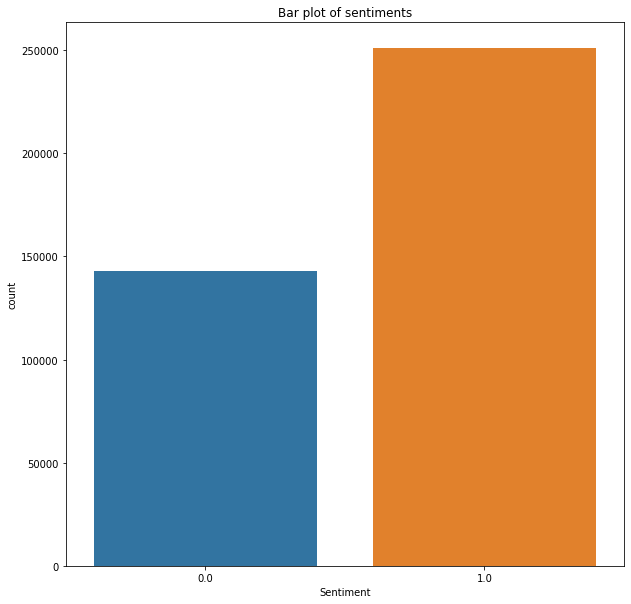

In [ ]:
plt.figure(figsize = (10,10))
sns.countplot(df['Sentiment'])
plt.title("Bar plot of sentiments") 

In [ ]:
#Spliting into train and test
train_df, test_df = train_test_split(df, test_size = 0.2, random_state = 42)
print("Training data size : ", train_df.shape)
print("Test data size : ", test_df.shape)

Training data size :  (315144, 11)
Test data size :  (78787, 11)


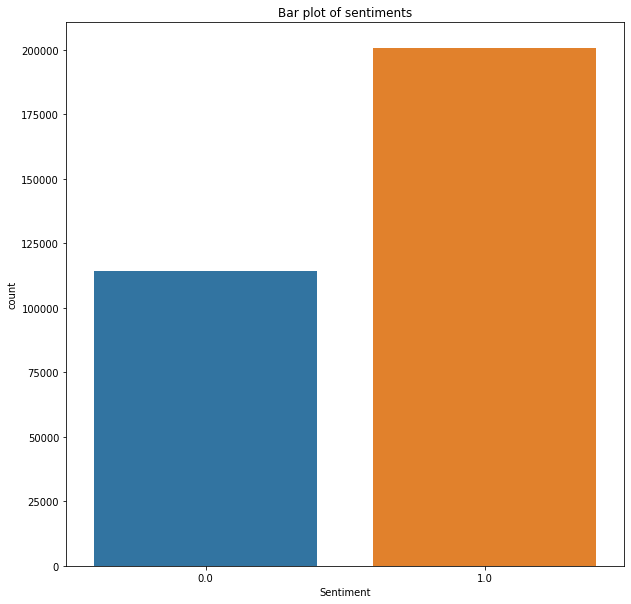

In [ ]:
#Distribution of the training set
plt.figure(figsize = (10,10))
sns.countplot(train_df['Sentiment'])
plt.title("Bar plot of sentiments") 
plt.show()

In [ ]:
train_df['Sentiment'].value_counts()

1.0    200738
0.0    114406
Name: Sentiment, dtype: int64

In [ ]:
test_df['Sentiment'].value_counts()

1.0    50228
0.0    28559
Name: Sentiment, dtype: int64

In [ ]:
top_words = 6000
tokenizer = Tokenizer(num_words=top_words)
tokenizer.fit_on_texts(train_df['Text'])
list_tokenized_train = tokenizer.texts_to_sequences(train_df['Text'])

In [ ]:
max_review_length = 130
X_train = pad_sequences(list_tokenized_train, maxlen=max_review_length)
y_train = train_df['Sentiment']

In [ ]:
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(top_words+1, embedding_vecor_length, input_length=max_review_length))
model.add(LSTM((1),batch_input_shape =  (None,393931,11),return_sequences = True ))
model.add(LSTM((1),return_sequences=False))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()




Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 130, 32)           192032    
_________________________________________________________________
lstm_2 (LSTM)                (None, 130, 1)            136       
_________________________________________________________________
lstm_3 (LSTM)                (None, 1)                 12        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 2         
Total params: 192,182
Trainable params: 192,182
Non-trainable params: 0
_________________________________________________________________


In [ ]:
mod = model.fit(X_train,y_train, epochs=10, batch_size=100, validation_split=0.2)

Epoch 1/10
2522/2522 [==============================] - 130s 52ms/step - loss: 0.3840 - accuracy: 0.8354 - val_loss: 0.4391 - val_accuracy: 0.8117
Epoch 2/10
2522/2522 [==============================] - 129s 51ms/step - loss: 0.3832 - accuracy: 0.8360 - val_loss: 0.4378 - val_accuracy: 0.8099
Epoch 3/10
2522/2522 [==============================] - 129s 51ms/step - loss: 0.3822 - accuracy: 0.8365 - val_loss: 0.4400 - val_accuracy: 0.8103
Epoch 4/10
2522/2522 [==============================] - 132s 52ms/step - loss: 0.3813 - accuracy: 0.8369 - val_loss: 0.4446 - val_accuracy: 0.8099
Epoch 5/10
2522/2522 [==============================] - 131s 52ms/step - loss: 0.3805 - accuracy: 0.8377 - val_loss: 0.4446 - val_accuracy: 0.8107
Epoch 6/10
2522/2522 [==============================] - 130s 52ms/step - loss: 0.3798 - accuracy: 0.8380 - val_loss: 0.4429 - val_accuracy: 0.8105
Epoch 7/10
2522/2522 [==============================] - 130s 52ms/step - loss: 0.3789 - accuracy: 0.8381 - val_loss: 0

In [ ]:
list_tokenized_test = tokenizer.texts_to_sequences(test_df['Text'])
X_test = pad_sequences(list_tokenized_test, maxlen=max_review_length)
y_test = test_df['Sentiment']
prediction = model.predict_classes(X_test)

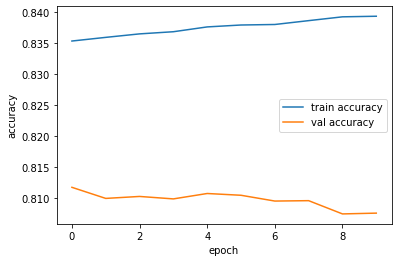

In [ ]:
plt.plot(mod.history['accuracy'], label='train accuracy')
plt.plot(mod.history['val_accuracy'], label='val accuracy')
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend();

In [ ]:
y_pred = (prediction > 0.5)
print("Accuracy of the model : ", accuracy_score(prediction, y_test))
print('F1-score: ', f1_score(prediction, y_test))
print('Confusion matrix:')
confusion_matrix(y_test,prediction)

Accuracy of the model :  0.8084709406374148
F1-score:  0.8533670197259742
Confusion matrix:


array([[19787,  8772],
       [ 6318, 43910]])

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, prediction ))

              precision    recall  f1-score   support

         0.0       0.76      0.69      0.72     28559
         1.0       0.83      0.87      0.85     50228

    accuracy                           0.81     78787
   macro avg       0.80      0.78      0.79     78787
weighted avg       0.81      0.81      0.81     78787



In [ ]:
plot_graphs()

array([[   0,    0,    0, ...,  132,   25,    5],
       [   0,    0,    0, ...,  786,   58,  298],
       [   0,    0,    0, ...,    6,   36,  127],
       ...,
       [   0,    0,    0, ...,   30,   89,  142],
       [   0,    0,    0, ...,  274,  702,   25],
       [   0,    0,    0, ...,  240,    1, 1087]], dtype=int32)

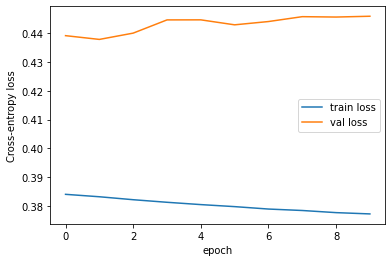

In [ ]:
plt.plot(mod.history['loss'], label='train loss')
plt.plot(mod.history['val_loss'], label='val loss')
plt.xlabel("epoch")
plt.ylabel("Cross-entropy loss")
plt.legend();